In [1]:
#Performing latent Dirichlet allocation (LDA) with gensim on the expanded demographic corpus

In [2]:
import pandas as pd
import spacy

In [3]:
#Keeping some quantitative information, dropping some superfluous columns

to_keep = ['text','species','laff','gender','missing','word_count', 'char_count', 'compound_score', 'subjectivity']
corpus = pd.read_csv('extended_corpus_processed.csv', header=0, usecols=to_keep)

In [4]:
#A quick peek

corpus.head()

,text,species,laff,gender,missing,word_count,char_count,compound_score,subjectivity
0,fashion show add me 7 left,cat,113,f,trap,6,26,0.0000,0.000000
1,thank you,duck,105,f,trap,2,9,0.3612,0.000000
2,i need like 4 bulls as well,rabbit,107,m,trap,7,27,0.5574,0.000000
3,but i dont wanna,rabbit,107,m,trap,4,16,0.0000,0.000000
4,lol cashbot is my only high one,rabbit,107,m,trap,7,31,0.4215,0.746667


In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
#Tokenizing each chat message

def tokenize_text(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return tokens

In [7]:
#Need to make sure all chat messages are strings as there are some integers in there

corpus['text'] = corpus['text'].apply(str)

In [8]:
corpus['tokens'] = corpus['text'].apply(tokenize_text)

In [9]:
#Using gensim for topic modeling

import gensim
from gensim import corpora

In [10]:
#Map words to integer IDs, then convert this document structure to a bag-of-words format

texts = corpus['tokens'].to_list()
dictionary = corpora.Dictionary(texts)
dict_corpus = [dictionary.doc2bow(text) for text in texts]

In [11]:
from gensim.models import LdaModel, CoherenceModel

In [12]:
#Calculating coherence scores to decide amount of passes to perform through the corpus with the LDA model

for passes in range(1, 11):
    lda_model = LdaModel(dict_corpus, num_topics=10, random_state=114, id2word=dictionary, passes=passes)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f'Passes: {passes}, Coherence score: {coherence_score}')

Passes: 1, Coherence score: 0.6243879644713977
Passes: 2, Coherence score: 0.6328548194738673
Passes: 3, Coherence score: 0.6336130571476557
Passes: 4, Coherence score: 0.6334634836432519
Passes: 5, Coherence score: 0.6363976529278321
Passes: 6, Coherence score: 0.6377830180814557
Passes: 7, Coherence score: 0.6377830180814557
Passes: 8, Coherence score: 0.6418399798037482
Passes: 9, Coherence score: 0.6418399798037482
Passes: 10, Coherence score: 0.6429117359980362


In [13]:
#A coherence score of >0.6 is generally considered good (topics are at least somewhat well-defined and semantically coherent)
#We'll go with 10 passes

In [14]:
lda_model = LdaModel(dict_corpus, num_topics=10, random_state=114, id2word=dictionary, passes=10)

In [15]:
#Checking out the top words for each topic

import pprint
pp = pprint.PrettyPrinter(indent=2)

In [16]:
topics = lda_model.show_topics(num_topics=10, num_words=20, formatted=False)

for t, words in topics:
  print(f"Topic {t + 1}:")
  pp.pprint([(word, round(prob,3)) for word, prob in words])
  print("\n")

Topic 1:
[ ('hi', 0.091),
  ('ill', 0.049),
  ('come', 0.038),
  ('day', 0.025),
  ('tp', 0.023),
  ('work', 0.019),
  ('party', 0.019),
  ('parade', 0.015),
  ('try', 0.012),
  ('minutes', 0.011),
  ('coins', 0.011),
  ('street', 0.011),
  ('boss', 0.01),
  ('greg', 0.009),
  ('drop', 0.009),
  ('xd', 0.008),
  ('guess', 0.007),
  ('follow', 0.007),
  ('hq', 0.007),
  ('small', 0.007)]


Topic 2:
[ ('got', 0.074),
  ('need', 0.056),
  ('bean', 0.05),
  ('ok', 0.036),
  ('y', 0.025),
  ('tysm', 0.025),
  ('idk', 0.02),
  ('guys', 0.016),
  ('jellybeans', 0.016),
  ('ta', 0.015),
  ('bad', 0.014),
  ('cannon', 0.012),
  ('change', 0.011),
  ('slay', 0.01),
  ('waiting', 0.01),
  ('plz', 0.01),
  ('tho', 0.009),
  ('thx', 0.008),
  ('tasks', 0.008),
  ('unite', 0.007)]


Topic 3:
[ ('lol', 0.122),
  ('s', 0.074),
  ('thank', 0.07),
  ('yeah', 0.028),
  ('m', 0.022),
  ('buy', 0.015),
  ('friend', 0.015),
  ('ttr', 0.015),
  ('okay', 0.013),
  ('cute', 0.013),
  ('long', 0.012),
  ('rn', 

In [17]:
#Assigning topic number to individual documents/messages

topic_assignments = []
for d in dict_corpus:
  topic_values = dict(lda_model[d])
  topic_number = max(topic_values.items(), key=lambda x: x[1])[0]
  topic_assignments.append(topic_number+1)

#LDA model holds list for each document with values indicating how well the document corresponds to each topic
#Grabbing maximum value indicating the topic in which the document fits most optimally
#Then looking up corresponding topic number

In [18]:
#Creating a new column in the corpus based on topic assignments

corpus['topic'] = topic_assignments

In [19]:
corpus.head()

,text,species,laff,gender,missing,word_count,char_count,compound_score,subjectivity,tokens,topic
0,fashion show add me 7 left,cat,113,f,trap,6,26,0.0000,0.000000,"[fashion, add, 7, left]",6
1,thank you,duck,105,f,trap,2,9,0.3612,0.000000,[thank],3
2,i need like 4 bulls as well,rabbit,107,m,trap,7,27,0.5574,0.000000,"[need, like, 4, bulls]",10
3,but i dont wanna,rabbit,107,m,trap,4,16,0.0000,0.000000,"[nt, wanna]",8
4,lol cashbot is my only high one,rabbit,107,m,trap,7,31,0.4215,0.746667,"[lol, cashbot, high]",3


In [20]:
#VISUALIZATION

In [21]:
#Quantitative metrics and topics

In [22]:
#Normalizing counts when visualizing because there are huge differences between demographic group sizes

def normalized_counts_pivot(data, category, metric):
  #takes in dataset, demographic category, category whose counts tp normalize
  proportions = data.groupby([category, metric]).size().reset_index(name='count')
  counts = proportions.groupby(category)['count'].sum()
  proportions['proportion'] = round(proportions['count'] / proportions[category].map(counts),3)
  pivot = proportions.pivot(index=category, columns=metric, values='proportion').fillna(0)
  return pivot

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
#Species

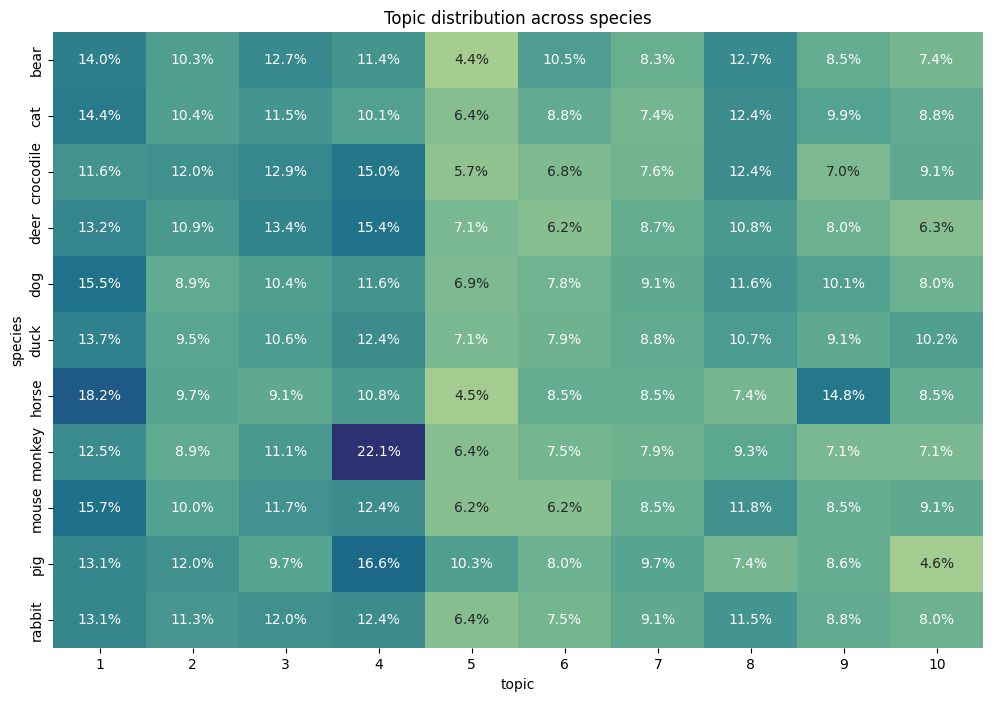

In [25]:
species_pivot = normalized_counts_pivot(corpus, 'species', 'topic')

plt.figure(figsize=(12, 8))
sns.heatmap(species_pivot, annot=True, cmap='crest', fmt='.1%', cbar=False)
plt.title('Topic distribution across species')
plt.show()

In [26]:
#Monkeys stand out for topic 4
#The top word for topic 4 is beans and beans is also the top word for monkeys
#This was uncovered in January 2024 demographic NLP research paper on extended corpus

In [27]:
#Gender

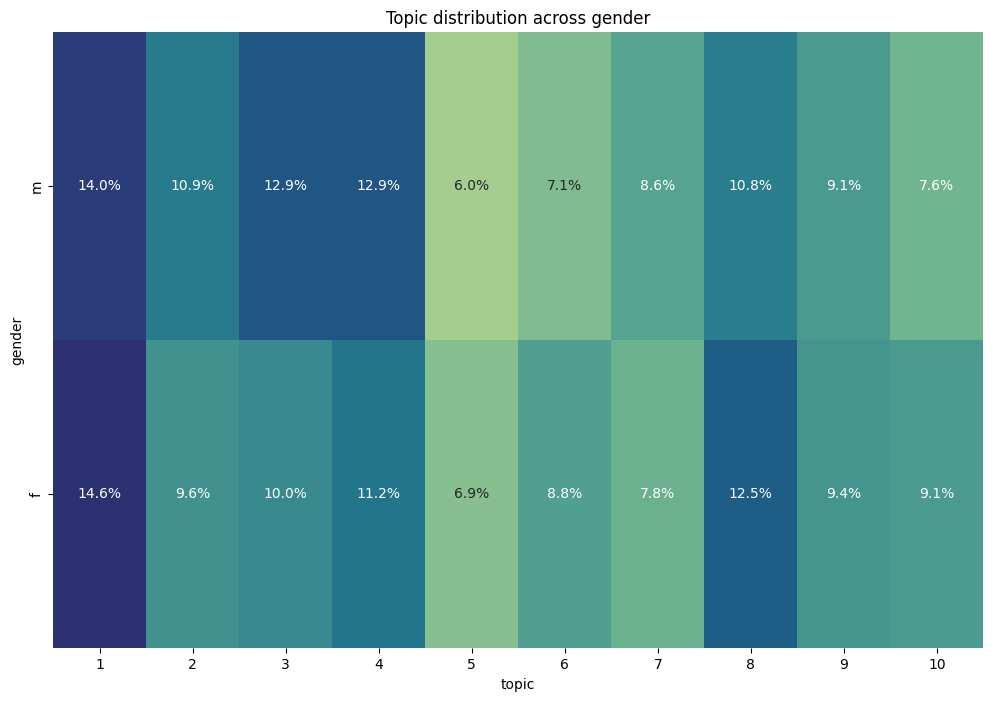

In [28]:
gender_pivot = normalized_counts_pivot(corpus, 'gender', 'topic')
gender_labels = ['m', 'f']

plt.figure(figsize=(12, 8))
sns.heatmap(gender_pivot, annot=True, cmap='crest', fmt='.1%', yticklabels = gender_labels, cbar=False)
plt.title('Topic distribution across gender')
plt.show()
#cbar_kws={'label': 'percentage'}

In [29]:
#Missing Gag track

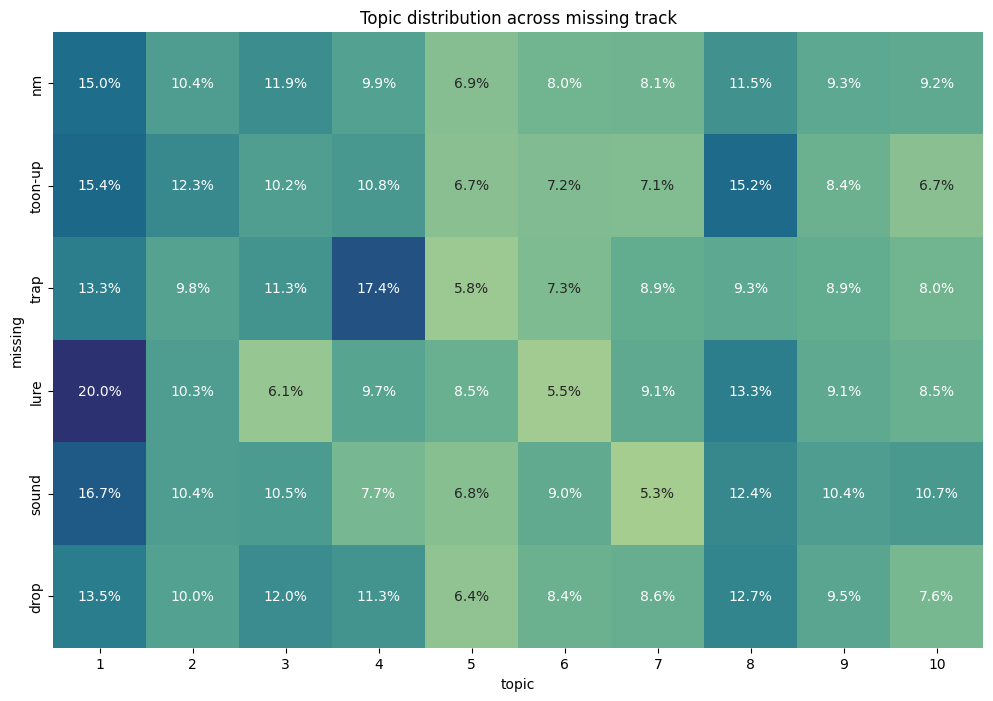

In [30]:
m_pivot = normalized_counts_pivot(corpus, 'missing', 'topic')
missing_labels = ['nm', 'toon-up', 'trap', 'lure', 'sound', 'drop']

plt.figure(figsize=(12, 8))
sns.heatmap(m_pivot, annot=True, cmap='crest', fmt='.1%', yticklabels = missing_labels, cbar=False)
plt.title('Topic distribution across missing track')
plt.show()

In [31]:
#Splitting dataset into categories for Laff
#Laff is a Toon's health and ranges from 15 to 140

bins = [15,19,29,39,49,59,69,79,89,99,109,119,129,139,140]
laff_labels = ['15-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119','120-129','130-139','140']
corpus['laff_range'] = pd.cut(corpus['laff'], bins=bins, labels=laff_labels, include_lowest=True).astype('string')

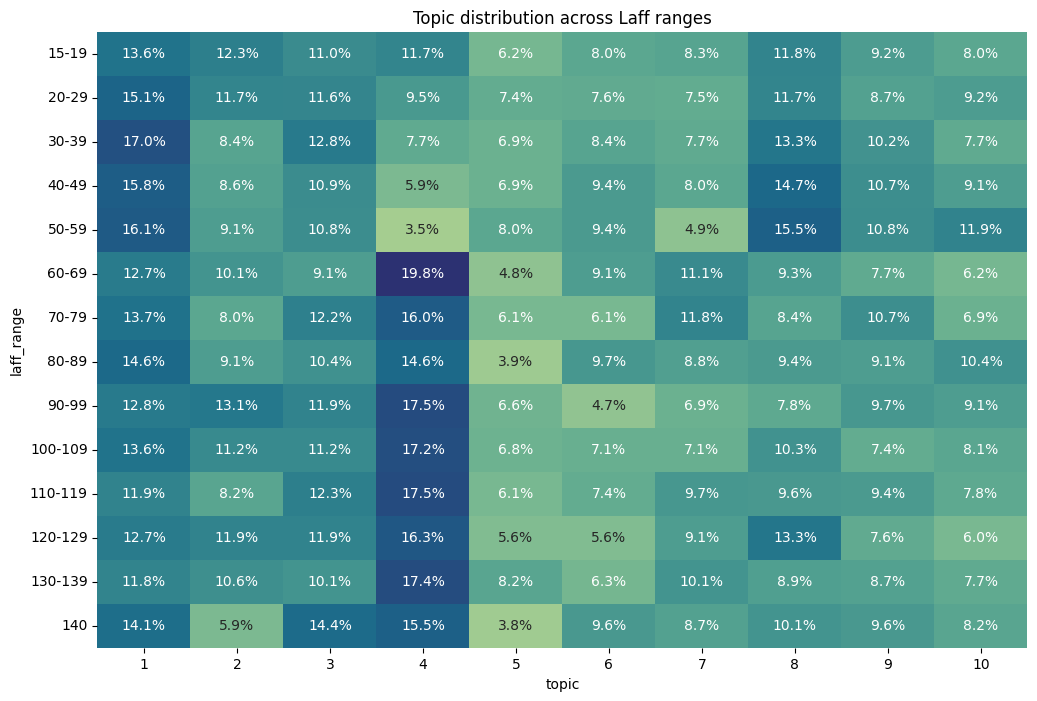

In [32]:
l_pivot = normalized_counts_pivot(corpus, 'laff_range', 'topic')

plt.figure(figsize=(12, 8))
sns.heatmap(l_pivot, annot=True, cmap='crest', fmt='.1%', yticklabels=laff_labels, cbar=False)
plt.title('Topic distribution across Laff ranges')
plt.show()

In [33]:
#Interestingly, topic 4 is much more popular among Toons with higher Laff
#"beans" is the top word for topic 4
#The frequency of "beans" as a token decreases as Laff increases and is much more popular for lower Laff individuals

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [34]:
#Quantitative metrics

In [35]:
#Message length in words

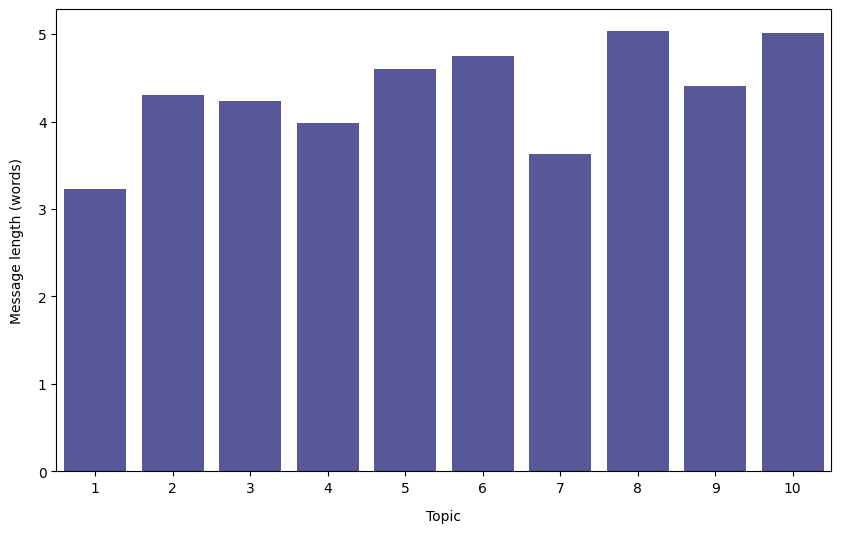

In [36]:
wl_info = corpus.groupby('topic')['word_count'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='topic', y='word_count', color='navy', alpha=0.7, data=wl_info)
plt.xlabel('Topic', labelpad=10)
plt.ylabel('Message length (words)', labelpad=10)
plt.show()

In [37]:
#Message length in characters

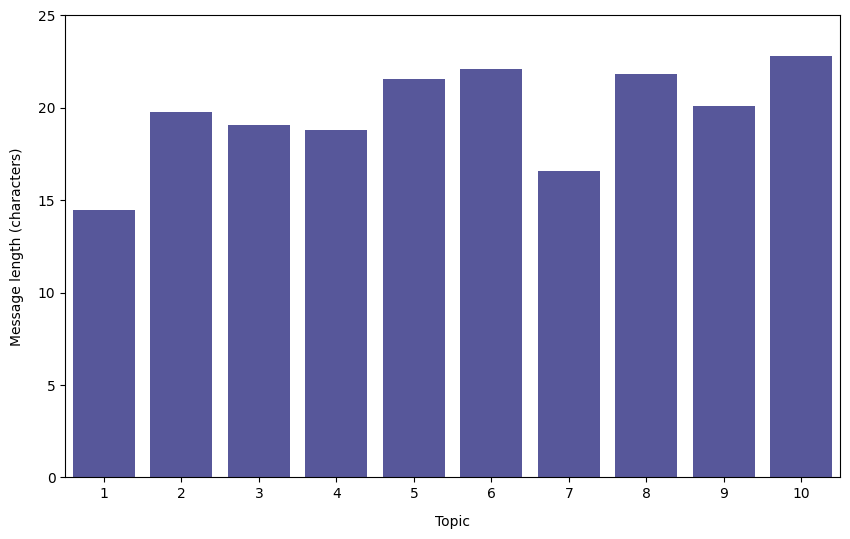

In [38]:
cl_info = corpus.groupby('topic')['char_count'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='topic', y='char_count', color='navy', alpha=0.7, data=cl_info)
plt.xlabel('Topic', labelpad=10)
plt.ylabel('Message length (characters)', labelpad=10)
plt.yticks(np.arange(0,26,5))
plt.show()

In [39]:
#Extreme similarity between the two plots

In [40]:
#Sentiment score

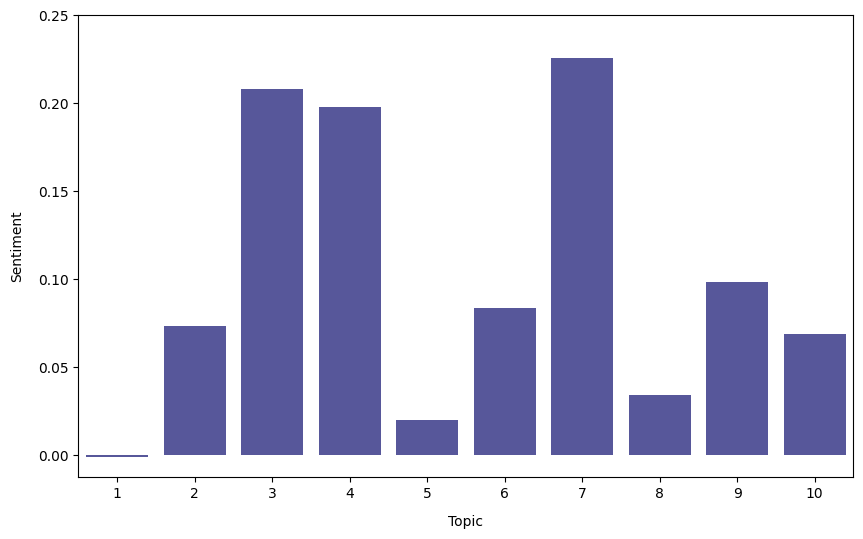

In [41]:
sent_info = corpus.groupby('topic')['compound_score'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='topic', y='compound_score', color='navy', alpha=0.7, data=sent_info)
plt.xlabel('Topic', labelpad=10)
plt.ylabel('Sentiment', labelpad=10)
plt.yticks(np.arange(0,0.26,0.05))
plt.show()

In [42]:
#Subjectivity

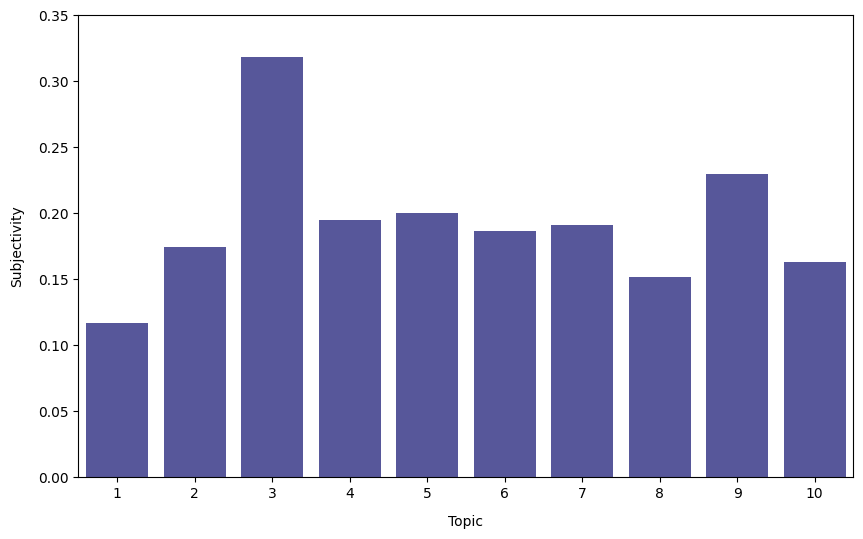

In [43]:
subj_info = corpus.groupby('topic')['subjectivity'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='topic', y='subjectivity', color='navy', alpha=0.7, data=subj_info)
plt.xlabel('Topic', labelpad=10)
plt.ylabel('Subjectivity', labelpad=10)
plt.yticks(np.arange(0,0.36,0.05))
plt.show()

In [44]:
#Interactive dashboard

In [47]:
import pyLDAvis
import pyLDAvis.gensim
import pickle

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, dict_corpus, dictionary)
#vis

In [ ]:
#Call vis to see interactive dashboard
#Distribution of topics, relationships between topics, most relevant terms for each topic